# SIMPRIM Pipeline Execution
### *On the BCIP 2012 benchmark Dataset*

In [7]:
import pandas as pd
import numpy as np

# Own modules
from utilities import utils
from optimization import OptimizationPipeline, VisualizePipelineResults


In [1]:
# Load data
import pm4py

# The data can be downloaded via: 
# https://data.4tu.nl/articles/dataset/BPI_Challenge_2012/126892041

log = pm4py.read_xes('./data/financial_log.xes')
data = pm4py.convert_to_dataframe(log)
del log

parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

## Pre-processing

In [2]:
from preprocessing import general as pp
    
data = pp.format_data(data)
data = pp.remove_running_journeys(data)
data = pp.add_journey_class(data)

# Save data
#utils.write_csv(data, 'clean_data.csv', index=False)

Removed running journeys (2.15%)


In [3]:
pp.make_train_test_datasets(data.drop_duplicates(subset=['journey_id']), # unique journey ids
                            nr_trainsets=1, 
                            nr_testsets=2, 
                            test_size=0.30, 
                            stratified=True) # stratified on class label


## Creating 2 journey ID sets for testing
29.99% of the total set is tested with
Saved feature names in a .txt file called 'journeyIDs_test_set_1.txt'
Saved feature names in a .txt file called 'journeyIDs_test_set_2.txt'

## Creating 1 journey ID sets for training
Saved feature names in a .txt file called 'journeyIDs_training_set_1.txt'
70.0% of the total set is trained with

Total number of sampled journeys: 12805


# Optimization Pipeline

In [5]:
# Parameters
param_dict = {  # Clustering
                'k':6,
                'medoids_init' : 'class_based', # class_based or kmeans++
                'cluster_RS' : [1,2,3,4,5],
                'train_quality' : True,
                
                # Feature set restrictions
                'test_featureset' : True,
                'min_similarity_contrast' : 0.2,
                'max_similar_vectors' : 0.25*(0.75*len(data)), # max_similar_threshold
                
                 # Weight optimization objective
                'theta_contribution_SDbw' : 0.7,
                'phi_contribution_AMI' : 0.3,
              
                 # Weight optimization stopping criteria
                'nr_calls_optimizer' : 150,
                'niters_no_improvement' : 60,
                'weight_optimization_plot' : True,
                
                # In case you want to continue weight optimization from a previous result
                'continue_from_optimization_file' : False,
                'previous_optimization_filename' : None,
                'previous_nr_calls_optimizer' : 0,

                'random_state' : 42
                }

## SIMPRIM Algorithm Step 1 and 2: finding $S_U^*$

In [10]:
for testSet in [1,2]:
    print('\n\n')
    OptimizationPipeline.baseline_pipeline( data, 
                                            sim_metrics=['cosine', 'jaccard'], 
                                            trace_types=['BOA', 'SOA'], 
                                            testset=testSet, 
                                            param_dict=param_dict)

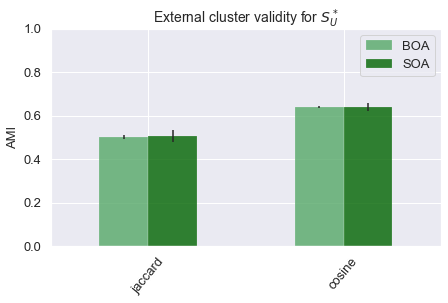

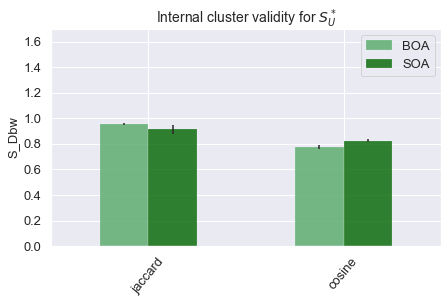

In [14]:
# Plot results
external_baselines, internal_baselines = VisualizePipelineResults.visualize_baseline_results(k=param_dict['k'], 
                                                                                            testsets=[1,2], 
                                                                                            saveFig=False)

## SIMPRIM Algorithm Step 3: finding $F(*)$ on which $S$ operates

In [9]:
# Optimal configs from previous step
metric = 'cosine'
ttype = 'BOA' # trace type

In [12]:
# Find feature sets on the Trainsets and test them on Testsets
for trainSet in [1]:
    for testSet in [1, 2]:
        OptimizationPipeline.feature_selection_pipeline(data, 
                                                     sim_metrics=[metric], 
                                                     trace_types=[ttype], 
                                                     feature_selectors=['Variance', 'Laplacian', 'L1', 'FCBF'], 
                                                     nr_features=[50, 100, 150], 
                                                     trainset=trainSet, testset=testSet, 
                                                     read_features_from_file=False, # if they're already found 
                                                     param_dict=param_dict)

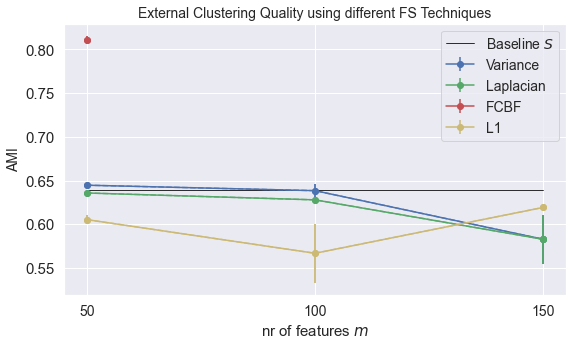

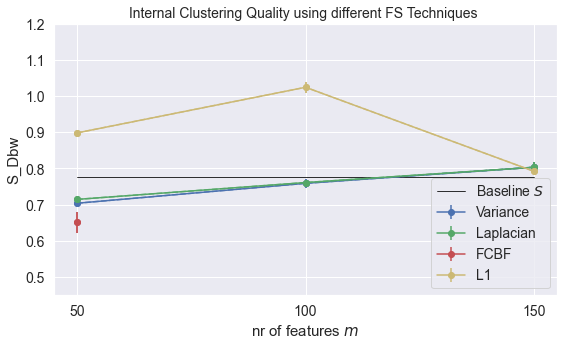

In [15]:
# Plot results
VisualizePipelineResults.visualize_features_results(param_dict['k'], 
                                                    metric=metric, 
                                                    ttype=ttype, 
                                                    nr_features=[50, 100, 150], 
                                                    xi=[0,1,2], 
                                                    trainsets=[1], testsets=[1,2], 
                                                    internal_baseline=internal_baselines[ttype][1], # 1 is cosine, 0 is jaccard
                                                    external_baseline=external_baselines[ttype][1],
                                                    feature_selectors=['FCBF','Variance','Laplacian','L1']
                                                   )

Note: FCBF only operates on 12 features which is considered to small to be selected as $F(*)$

## Weight Optimization

In [16]:
# Optimal configs from previous step
SelectionTechnique = 'Variance'
m = 50 # nr features

In [19]:
for trainSet in [1]:
    for testSet in [1, 2]:
        OptimizationPipeline.weight_optimization_pipeline(data, 
                                               metric=metric, 
                                               trace_type=ttype, 
                                               feature_selector=SelectionTechnique, 
                                               nr_features=[m],
                                               weight_models=['Gradient Boosting', 'Gaussian'], 
                                               trainset=trainSet, testset=testSet, 
                                               read_weights_from_file=False, # if they are already found
                                               param_dict=param_dict)

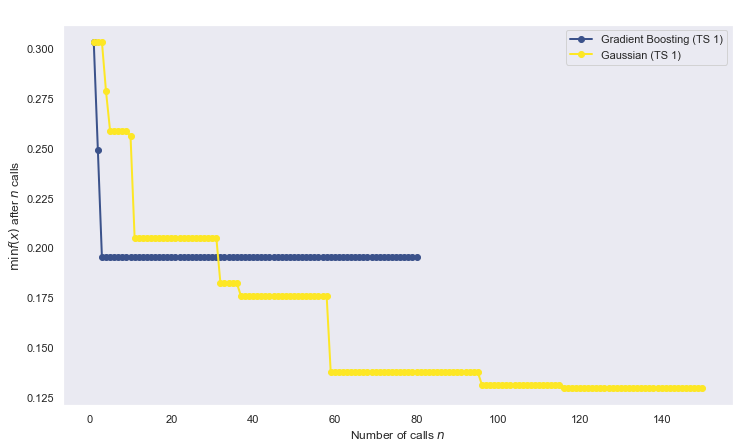

In [20]:
VisualizePipelineResults.weight_convergence_plot([1], SelectionTechnique, m, metric, ttype, param_dict['nr_calls_optimizer'])

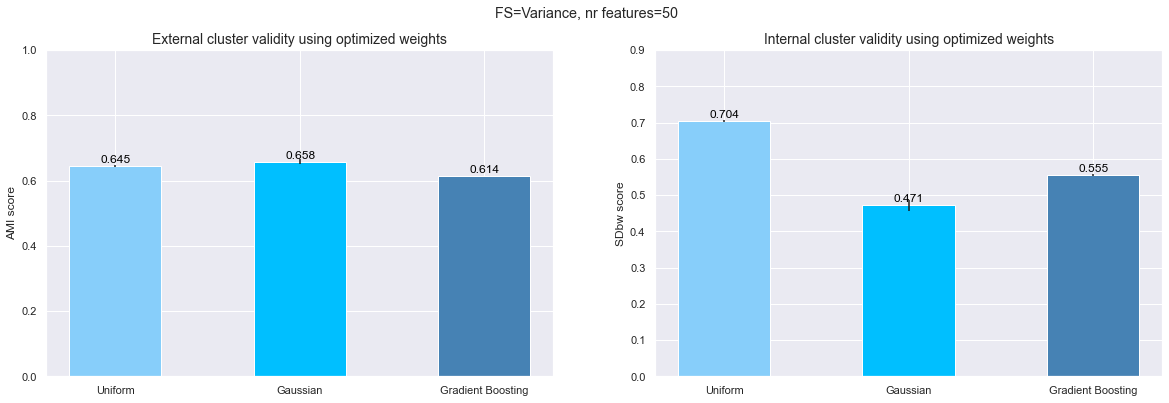

In [21]:
VisualizePipelineResults.visualize_weights_results(k = param_dict['k'], 
                                                   metric = metric, 
                                                   ttype = ttype, 
                                                   SelectionTechnique = SelectionTechnique, 
                                                   nr_ftrs = [m], 
                                                   optimizers = ['Uniform', 'Gaussian', 'Gradient Boosting'], 
                                                   nr_calls_optimizer = param_dict['nr_calls_optimizer'], 
                                                   trainsets=[1], 
                                                   testsets=[1,2])

## Optimal Clustering $TC$

In [22]:
# Optimal configs from previous (final) step
weight_model='Gradient Boosting'

In [23]:
# Clustering the test journeys with S*

testIDs1 = utils.read_list_from_txt('journeyIDs_test_set_1.txt')       
#testIDs2 = utils.read_list_from_txt('journeyIDs_test_set_2.txt')       
journeysIDs_to_cluster = testIDs1#+testIDs2

features, weights, test_trace_df, medoids_df = OptimizationPipeline.clustering_with_optimal_pipeline(data, 
                                                                                  metric, 
                                                                                  ttype, 
                                                                                  SelectionTechnique, 
                                                                                  m, 
                                                                                  weight_model, 
                                                                                  journeysIDs_to_cluster, 
                                                                                  trainset=1, 
                                                                                  param_dict=param_dict)

Vectorizing the data

Removing non-variance features...
Removed: 453 features

Removing perfectly correlating features...
Removed: 20 features
Shape data to cluster: (1920, 197)

Clustering with different random states:
	Calculating pairwise distance matrix...
	Clustering with Random State: 1
	Clustering with Random State: 2
	Clustering with Random State: 3
	Clustering with Random State: 4
	Clustering with Random State: 5

Clustering again with the optimal random state..
Best random state: 1 

Done!


### Comparing Clusters Labels and Journey Labels

In [24]:
# Cluster dist
print('Cluster Distribution')
print(test_trace_df['cluster_label'].value_counts(normalize=True))

# Class dist
print('\nClass Distribution')
print(data.drop_duplicates(subset=['journey_id'])['journey_class'].value_counts(normalize=True))

Cluster Distribution
1    0.317188
5    0.270833
0    0.154167
3    0.107292
4    0.092708
2    0.057813
Name: cluster_label, dtype: float64

Class Distribution
R_straight     0.533620
C_offer        0.137212
A_straight     0.120109
C_straight     0.091136
R_offer        0.062632
A_optimized    0.055291
Name: journey_class, dtype: float64
